# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [1]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP
from joblib import dump, load
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from typing import Union, Any
import statistics


from utils.common import *
from utils.dataset import CS4220Dataset
from utils.model_evaluation import _read_model, get_all_jaccard_index, performance_evaluate

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap.plot
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
# Check the current working directory
%pwd

'/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection'

## Testing Utils

In [49]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_selector(X,y):
    model = RandomForestRegressor(random_state=1, max_depth=10)
    model.fit(X,y)
    features = df.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-9:]  # top 10 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

def create_coarse_labels(df):
    df['coarse_species_name'] = np.where(df['species_name'] != "decoy", "non_decoy", "decoy")
    le = preprocessing.LabelEncoder()
    le.fit(df['coarse_species_name'].unique())
    y_index = le.transform(df['coarse_species_name'].values)
    df['labels'] = y_index
    print(f"Unique labels {len(df['coarse_species_name'].unique())}")
    return df, le

def jaccard_index_per_patient(patient_id:str, preds):
    # Generic filename
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp) , preds, df_true['labels'].values

def get_all_jaccard_index_with_transformation( model:Any, label_encoder:Any , x_transformer:Any, num_patients:int=10, threshold:float=0.95):

    all_jaccard_index = []
    all_pred = []
    all_true = []
    for patient_id in range(num_patients):
        print('predicting for patient {}'.format(patient_id))

        with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
            df_test = np.load(read_file)

        # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
        transformed_data =x_transformer.fit_transform(df_test)
        y_pred = model.predict(transformed_data)

        # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
        # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
        y_predprob = model.predict_proba(transformed_data)

        # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
        final_predictions = label_encoder.inverse_transform(
                                np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                            ))

        # my pathogens dectected, decoy will be ignored
        final_predictions = [item for item in final_predictions if item !='decoy']

        ji, pred_pathogen, true_pathogen = jaccard_index_per_patient(patient_id, final_predictions)
        print('Jaccard index: {}'.format(ji))
        all_jaccard_index.append(ji)    
        all_pred.append(pred_pathogen)
        all_true.append(true_pathogen)

    return all_jaccard_index, flatten(all_pred), flatten(all_true)

def flatten(original_list:list):
    return list(chain.from_iterable(original_list))

def get_kmer_analysis_map(dataset):
    test = dataset.X_mapped.copy()
    test["labels"] = dataset.Y   
    return test.groupby("labels").mean().reset_index()
    
    
def getting_no_kmer_existence(analysis):

    kmer_by_label = dict()
    # Obtaining the profile
    for elem in analysis.index:
        kmer_by_label[elem] = analysis.iloc[elem,1:-1]

    # Getting label without that kmer
    for elem in analysis.index:
        kmer_zero = list(kmer_by_label[elem][kmer_by_label[elem]==0].index)
        if (len(kmer_zero) > 0):
            print(f" label {elem} ::  {kmer_zero}")

    return kmer_zero

def get_label_by_kmer(kmer_analysis):
    label_profile_by_kmer = dict()

    # Obtaining the profile
    for elem in range(1,len(kmer_analysis.columns)-1):
        label_profile_by_kmer[kmer_analysis.columns[elem]] = kmer_analysis.iloc[:,elem]
    return label_profile_by_kmer

def get_std_across_labels_by_kmer(kmer_analysis):
    label_profile_by_kmer = get_label_by_kmer(kmer_analysis)

    std_accross_labels = dict()

    for key, values in label_profile_by_kmer.items():
        std_accross_labels[key] = np.std(values)

    # Sort by variation
    std_accross_labels_sorted = dict(sorted(std_accross_labels.items(), key=lambda item: item[1]))

    return std_accross_labels_sorted

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [50]:
label_df = pd.read_csv('./training_data/train_labels.csv')
get_species_count(label_df)

(461581,
 species_name
 decoy                              413476
 burkholderia_pseudomallei            3533
 pseudomonas_aeruginosa               3126
 klebsiella_michiganensis             2989
 mycobacterium_ulcerans               2910
 klebsiella_pneumoniae                2806
 serratia_liquefaciens                2629
 vibrio_parahaemolyticus              2579
 salmonella_enterica_typhimurium      2507
 yersinia_enterocolitica              2276
 stenotrophomonas_maltophilia         2217
 mycobacterium_tuberculosis           2175
 clostridioides_difficile             2007
 acinetobacter_baumannii              1964
 legionella_pneumophila               1753
 listeria_monocytogenes               1479
 staphylococcus_aureus                1384
 staphylococcus_pseudintermedius      1328
 corynebacterium_ulcerans             1266
 corynebacterium_diphtheriae          1194
 streptococcus_suis                   1092
 neisseria_gonorrhoeae                1087
 streptococcus_agalactiae      

In [87]:
unique_species = label_df['species_name'].unique()
len(unique_species)

26

In [51]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
processed_label_df ,label_encoder = create_label_df(label_df)
#this label_df will have label index instead of the actual class value

Unique labels 26


In [52]:
#500 here means that there are at most 500 per label class
# find ways to reduce the sample size as there are >10000 samples

samples_500_index = create_sampling_idx(label_df,500)
display(samples_500_index)

Index([ 1595,  1088,  1645,   403,   686,   702,   994,   409,  1032,   987,
       ...
       46869, 48048, 47371, 47754, 46223, 47183, 47702, 46233, 46954, 46011],
      dtype='int64', length=13000)

In [53]:
# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df, samples_index=samples_500_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(sampled_dataset.Y))

13000 2080
13000


In [56]:
# Using all data
all_dataset = CS4220Dataset(data_file=input_file_path, label_df=processed_label_df)
print(len(all_dataset.X[:, :-1]), len(all_dataset.X[:, :-1][0])) # each row represent the sequence and each featuere represent the unique k-mers profile and the values represent the frequencies to it; exclude the last col as that is ambiguous
print(len(all_dataset.Y))

461581 2080
461581


In [57]:
kmer_analysis = get_kmer_analysis_map(all_dataset)

# For entire dataset
kmer_zero=getting_no_kmer_existence(kmer_analysis)
std_accross_labels_sorted=get_std_across_labels_by_kmer(kmer_analysis) 
all_dataset_features_to_drop = [key for key, elem in std_accross_labels_sorted.items() if elem <  0.0001 ] #highlight those k-mers with have very little std_dev across the labels will be removed
len(all_dataset_features_to_drop)

 label 3 ::  ['CGATCG']


145

In [60]:
columns_to_drop_indices = [all_dataset.X_mapped.columns.get_loc(col) for col in all_dataset_features_to_drop if col in all_dataset.X_mapped.columns]
len(columns_to_drop_indices)


145

In [61]:
all_dataset.X_mapped=all_dataset.X_mapped.drop(columns=all_dataset_features_to_drop)
all_dataset.X = np.delete(all_dataset.X, columns_to_drop_indices, axis=1)

print(all_dataset.X_mapped.shape)
print(len(all_dataset.X[0]))


(461581, 1936)
[[0.004612  0.002356  0.002453  ... 0.0006866 0.001276  0.       ]
 [0.005604  0.002802  0.002308  ... 0.0003295 0.001318  0.       ]
 [0.001314  0.00219   0.000438  ... 0.000876  0.001314  0.       ]
 ...
 [0.001113  0.0001855 0.001299  ... 0.000371  0.0005565 0.       ]
 [0.003672  0.00178   0.00356   ... 0.0003338 0.0003338 0.       ]
 [0.00379   0.001813  0.002472  ... 0.0001647 0.0004945 0.       ]]


### Training Model for Logistic Regression and Random Forest with filtered features (Those kmers with more than 0.001 std_dev across the labels)

In [67]:
starting_time = timeit.default_timer()
regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(all_dataset.X[:, :-1], all_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)

Epoch 2, change: 0.29142934


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 3, change: 0.15740997
Epoch 1, change: 1.00000000
Epoch 4, change: 0.12489472
Epoch 2, change: 0.27893914
Epoch 5, change: 0.08396058
Epoch 3, change: 0.16392318
Epoch 6, change: 0.06676081
Epoch 4, change: 0.11658781
Epoch 7, change: 0.05865634
Epoch 5, change: 0.08691630
Epoch 8, change: 0.04549436
Epoch 6, change: 0.07102034
Epoch 9, change: 0.04657918
Epoch 7, change: 0.05436866
Epoch 8, change: 0.04659784
Epoch 10, change: 0.04411398
Epoch 9, change: 0.04351795
Epoch 11, change: 0.03046815
Epoch 10, change: 0.04163979
Epoch 12, change: 0.03053868
Epoch 11, change: 0.03204020
Epoch 13, change: 0.02499932
Epoch 12, change: 0.03019392
Epoch 14, change: 0.02587943
Epoch 13, change: 0.02612904
Epoch 15, change: 0.02584357
Epoch 14, change: 0.02928871
Epoch 16, change: 0.02216247
Epoch 15, change: 0.02490922
Epoch 17, change: 0.02224175
Epoch 16, change: 0.02644092
Epoch 18, change: 0.02167825
Epoch 17, change: 0.02565044
Epoch 19, change: 0.02129514
Epoch 18, change: 0.02200394
E

In [68]:
regr_2=regr
dump(regr_2, 'models/log_reg_fs1.joblib')

['models/lr_fs1.joblib']

In [82]:
from sklearn.ensemble import RandomForestClassifier
starting_time = timeit.default_timer()
clf_2 = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=16)
# Train the model using the training sets
clf_2.fit(all_dataset.X[:, :-1], all_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(clf_2, 'models/rf_fs1.joblib')

Time taken : 2704.0378156670195


['models/rf_fs1.joblib']

In [23]:
len(std_accross_labels_sorted)


2080

In [11]:
# For sampled dataset

kmer_analysis = get_kmer_analysis_map(sampled_dataset)

kmer_zero= getting_no_kmer_existence(kmer_analysis)

std_accross_labels_sorted= get_std_across_labels_by_kmer(kmer_analysis)

sampled_features_to_drop = [key for key, elem in std_accross_labels_sorted.items() if elem <  0.0001 ]
len(sampled_features_to_drop)

 label 3 ::  ['CGATCG', 'CGCGCG']


134

In [12]:
# Check if any column is 0
# Get Each row
kmer_profile_by_label = dict()
for elem in kmer_analysis.index:
    kmer_profile_by_label[elem] = kmer_analysis.iloc[elem,1:-1]


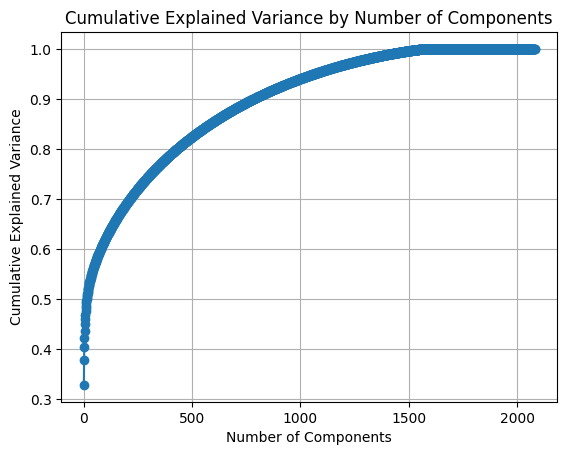

In [65]:
pca = PCA(n_components=2080)  # Use the maximum number of components
pca.fit(sampled_dataset.X[:, :-1])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [14]:
# Create 900 components which make uo 90% of variance
pca = PCA(n_components=900) 
pca.fit(sampled_dataset.X[:, :-1])
print(f"Total explained variance {sum(pca.explained_variance_ratio_)}")

Total explained variance 0.9209286438909671


In [15]:
# Getting x fits
X_pca_components = pca.fit_transform(sampled_dataset.X[:, :-1])

In [ ]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_pca_components, sampled_dataset.Y)
dump(regr, 'models/pca_lr.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

### Training Model for Logistic Regression and Random Forest with PCA feature reduction on top of the filtering

In [81]:
pca = PCA(n_components=900) 
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

X_pca_components = pca.fit_transform(all_dataset.X[:, :-1])
starting_time = timeit.default_timer()

regr_3 = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=20, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_pca_components, all_dataset.Y)
dump(regr_3, 'models/log_reg_fs2.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

Epoch 30, change: 0.01126083
Epoch 31, change: 0.01118327
Epoch 32, change: 0.01080629
Epoch 33, change: 0.00987388


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 34, change: 0.00984826
Epoch 2, change: 0.27463205
Epoch 35, change: 0.00987016
Epoch 3, change: 0.14786775
Epoch 36, change: 0.01015087
Epoch 4, change: 0.09818033
Epoch 37, change: 0.01019124
Epoch 5, change: 0.07527873
Epoch 38, change: 0.01109149
Epoch 6, change: 0.06235189
Epoch 39, change: 0.00959889
Epoch 7, change: 0.04872779
Epoch 40, change: 0.00860769
Epoch 8, change: 0.04358412
Epoch 41, change: 0.00913201
Epoch 9, change: 0.03821756
Epoch 42, change: 0.00955997
Epoch 10, change: 0.02953930
Epoch 43, change: 0.00849882
Epoch 11, change: 0.03093227
Epoch 44, change: 0.00824782
Epoch 12, change: 0.02607388
Epoch 45, change: 0.00803808
Epoch 13, change: 0.02432356
Epoch 46, change: 0.00730894
Epoch 14, change: 0.02388251
Epoch 47, change: 0.00781831
Epoch 15, change: 0.02228670
Epoch 48, change: 0.00839085
Epoch 16, change: 0.02022947
Epoch 49, change: 0.00785946
Epoch 17, change: 0.01907136
Epoch 50, change: 0.00839916
Epoch 18, change: 0.019

In [83]:
from sklearn.ensemble import RandomForestClassifier
starting_time = timeit.default_timer()
clf_3 = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=16)
# Train the model using the training sets
clf_3.fit(X_pca_components, all_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)
dump(clf_3, 'models/rf_fs2.joblib')

Time taken : 4128.793724457995


['models/rf_fs2.joblib']

 Macro Precision :  0.88, Recall :  0.88, F1 :  0.88
 Micro Precision :  0.88, Recall :  0.88, F1 :  0.88


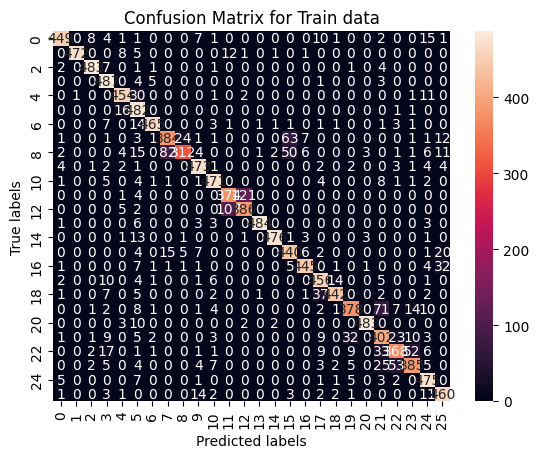

 Macro Precision :  0.88, Recall :  0.88, F1 :  0.88
 Micro Precision :  0.88, Recall :  0.88, F1 :  0.88


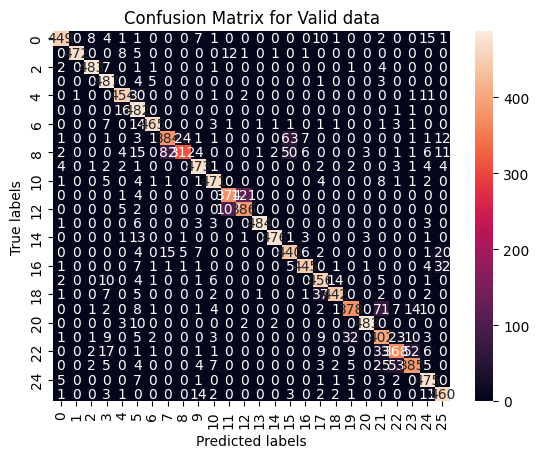

predicting for patient 0
my predition(s) for patient 0:
['neisseria_gonorrhoeae', 'stenotrophomonas_maltophilia']
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
my predition(s) for patient 1:
[]
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['clostridioides_difficile', 'listeria_monocytogenes', 'stenotrophomonas_maltophilia']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 3
my predition(s) for patient 3:
['campylobacter_jejuni', 'stenotrophomonas_maltophilia']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.0
predicting for patient 4
my predition(s) for patient 4:
['stenotrophomonas_maltophilia']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
['neisseria_gonorrhoeae', 'stenotrophomonas_maltophilia']
true pathogen
['streptococcus_pne

In [34]:
performance_evaluate(
    train_dataset=(X_pca_components, sampled_dataset.Y),
    valid_dataset=(X_pca_components, sampled_dataset.Y),
    model_name="pca_lr",
    filepath="models"
)

model =_read_model(filepath="models", model_name="pca_lr")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index_with_transformation(model=model, label_encoder=label_encoder,x_transformer=pca)

In [21]:
mapper = UMAP().fit(sampled_dataset.X[:, :-1])

In [23]:
mapper.fit_transform(sampled_dataset.X[:, :-1])

array([[-0.4374574 ,  2.8095446 ],
       [-0.96477807,  3.3785427 ],
       [-0.2725807 ,  2.9482372 ],
       ...,
       [ 2.4289954 , -0.42871734],
       [ 2.480989  , -0.57144594],
       [ 2.2368786 ,  0.03353956]], dtype=float32)

The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

In [11]:
from sklearn.model_selection import train_test_split
# Having a training/validation set
X_train, X_test, y_train, y_test = train_test_split(sampled_dataset.X, sampled_dataset.Y,
                                                    stratify=sampled_dataset.Y, 
                                                    test_size=0.25)

In [12]:
# Using a smaller lightweight model
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)

dump(clf, 'models/nb_model.joblib')

['models/nb_model.joblib']

In [15]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=20, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(X_train, y_train)
dump(regr, 'models/log_reg.joblib')
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28101461
Epoch 3, change: 0.20038747
Epoch 4, change: 0.15242559
Epoch 5, change: 0.12505654
Epoch 6, change: 0.10573650
Epoch 7, change: 0.09499900
Epoch 8, change: 0.08598759
Epoch 9, change: 0.07898506
Epoch 10, change: 0.07285994
Epoch 11, change: 0.06688776
Epoch 12, change: 0.06172971
Epoch 13, change: 0.05686876
Epoch 14, change: 0.05233452
Epoch 15, change: 0.04802390
Epoch 16, change: 0.04477193
Epoch 17, change: 0.04161416
Epoch 18, change: 0.03887196
Epoch 19, change: 0.03642944
Epoch 20, change: 0.03420195
max_iter reached after 63 seconds
Time taken : 62.572902916000004


/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=regr, label_encoder=label_encoder)

predicting for patient 0
my predition(s) for patient 0:
[]
true pathogen
['staphylococcus_aureus']
Jaccard index: 0.0
predicting for patient 1
my predition(s) for patient 1:
[]
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.5
predicting for patient 3
my predition(s) for patient 3:
[]
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.0
predicting for patient 4
my predition(s) for patient 4:
[]
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
[]
true pathogen
['streptococcus_pneumoniae']
Jaccard index: 0.0
predicting for patient 6
my predition(s) for patient 6:
[]
true pathogen
['mycobacterium_ulcerans']
Jaccard index: 0.0
predicting for patient 7
my predition(s) for patient 7:
['clostridioides_difficile']
true pathogen
['my

 Macro Precision :  0.83, Recall :  0.80, F1 :  0.80
 Micro Precision :  0.80, Recall :  0.80, F1 :  0.80


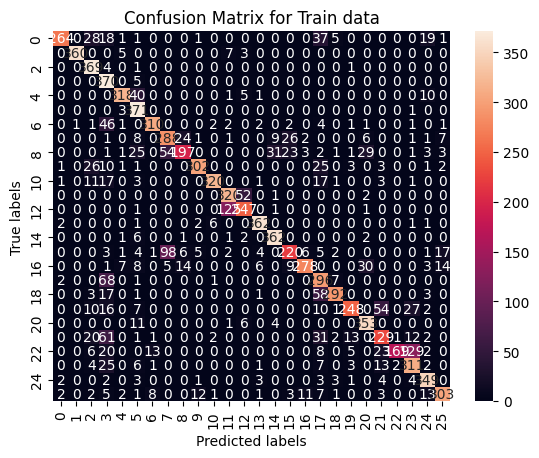

 Macro Precision :  0.82, Recall :  0.79, F1 :  0.79
 Micro Precision :  0.79, Recall :  0.79, F1 :  0.79


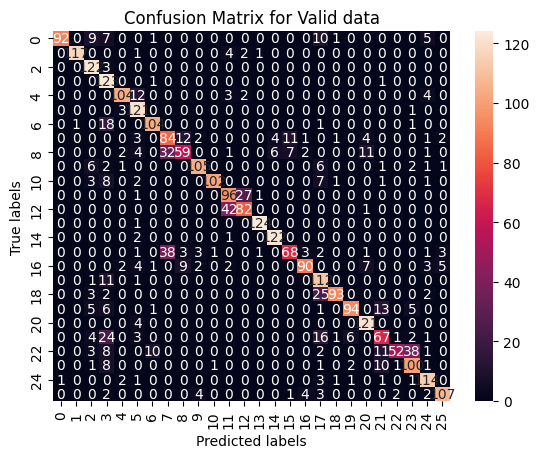

In [16]:

performance_evaluate(
    train_dataset=(X_train, y_train),
    valid_dataset=(X_test,y_test),
    model_name="log_reg",
    filepath="models"
)

In [41]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 6, change: 0.11266158
Epoch 1, change: 1.00000000
Epoch 7, change: 0.09846733
Epoch 2, change: 0.36959501
Epoch 3, change: 0.22549589
Epoch 8, change: 0.08723684
Epoch 4, change: 0.16383981
Epoch 9, change: 0.07821385
Epoch 5, change: 0.13149948
Epoch 10, change: 0.07094194
Epoch 6, change: 0.11140447
Epoch 11, change: 0.06377122
Epoch 7, change: 0.09730791
Epoch 12, change: 0.05783596
Epoch 8, change: 0.08619516
Epoch 13, change: 0.05263313
Epoch 9, change: 0.07755324
Epoch 14, change: 0.04830091
Epoch 10, change: 0.07021079
Epoch 15, change: 0.04427609
Epoch 11, change: 0.06334869
Epoch 16, change: 0.04116502
Epoch 12, change: 0.05726081
Epoch 17, change: 0.03808542
Epoch 13, change: 0.05218956
Epoch 18, change: 0.03529336
Epoch 14, change: 0.04784638
Epoch 19, change: 0.03318797
Epoch 15, change: 0.04393941
Epoch 20, change: 0.03107522
Epoch 16, change: 0.04067527
Epoch 21, change: 0.02917567
Epoch 17, change: 0.03796250
Epoch 22, change: 0.02749146
Epoch 18, change: 0.0352185

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [ ]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

### Trying out the GridSearchCV method he suggested but takes even longer and coef_ did not coverge as max_iter of 500 is reached

In [42]:
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
Epoch 2, change: 0.78394006
Epoch 2, change: 0.23476796
Epoch 2, change: 0.92647704
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


KeyboardInterrupt: 

Epoch 56, change: 0.00896325
Epoch 57, change: 0.00874027


In [ ]:
np.random.random()

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [8]:
baseline_model =_read_model(filepath="models", model_name="baseline")
all_jaccard_index, all_pred, all_true = get_all_jaccard_index(model=baseline_model, label_encoder=label_encoder)

/Users/melloo21/opt/anaconda3/envs/cs4220_pathogen_detection/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


predicting for patient 0
my predition(s) for patient 0:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
Jaccard index: 1.0
predicting for patient 1
my predition(s) for patient 1:
['neisseria_gonorrhoeae']
true pathogen
['staphylococcus_pyogenes']
Jaccard index: 0.0
predicting for patient 2
my predition(s) for patient 2:
['burkholderia_pseudomallei', 'clostridioides_difficile', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
Jaccard index: 0.6666666666666666
predicting for patient 3
my predition(s) for patient 3:
['clostridioides_difficile', 'pseudomonas_aeruginosa', 'staphylococcus_pseudintermedius', 'yersinia_enterocolitica']
true pathogen
['pseudomonas_aeruginosa']
Jaccard index: 0.25
predicting for patient 4
my predition(s) for patient 4:
['staphylococcus_pseudintermedius']
true pathogen
['corynebacterium_diphtheriae']
Jaccard index: 0.0
predicting for patient 5
my predition(s) for patient 5:
['streptococcus_pneumo

In [16]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.6666666666666666', 'patient 3: 0.25', 'patient 4: 0.0', 'patient 5: 1.0', 'patient 6: 0.0', 'patient 7: 0.16666666666666666', 'patient 8: 0.3333333333333333', 'patient 9: 0.25'] avg: 0.36666666666666664


In [12]:
set(all_true)

{'burkholderia_pseudomallei',
 'corynebacterium_diphtheriae',
 'corynebacterium_ulcerans',
 'mycobacterium_tuberculosis',
 'mycobacterium_ulcerans',
 'pseudomonas_aeruginosa',
 'staphylococcus_aureus',
 'staphylococcus_pyogenes',
 'streptococcus_pneumoniae'}

In [10]:
set(all_pred)

{'burkholderia_pseudomallei',
 'clostridioides_difficile',
 'corynebacterium_ulcerans',
 'listeria_monocytogenes',
 'neisseria_gonorrhoeae',
 'pseudomonas_aeruginosa',
 'staphylococcus_aureus',
 'staphylococcus_pseudintermedius',
 'streptococcus_pneumoniae',
 'yersinia_enterocolitica'}

So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!